In [64]:
import cvxpy as cp
import numpy as np
import networkx as nx
import pickle as pkl
from matplotlib import pyplot as plt
from matplotlib import rc


In [2]:
def consensus_weight(A):
    '''
        Given the sparsity A, find the best doubly stochastic consensus weight matrix W that
        matches the sparsity pattern A and minimizes ||W-1/n 11^T||_2.
    '''
    M = 2 # The 'BIG M' parameter. It is big compared to the entries of W.
    n_dim = len(A)

    W = cp.Variable(shape = (n_dim,n_dim),symmetric=True)

    constraints = [W>=-M*A,W<=M*A,W>=0,cp.sum(W,axis=1)==1]
    obj = cp.Minimize(cp.norm(W-1/n_dim * np.ones((n_dim,n_dim))))
    prob = cp.Problem(obj,constraints)
    prob.solve()

    W.value[W.value<1e-4]=0
    return W.value

In [79]:
def best_network(n_dim,deg):
    As = []
    Ws = []
    s = []
    for _ in range(1000):
        G = nx.random_regular_graph(deg,n_dim)
        while not nx.is_connected(G):# Ensure G is connected
            G = nx.random_regular_graph(deg,n_dim)
            
        A = nx.adj_matrix(G).todense()+np.eye(n_dim)
        W = consensus_weight(A)
        As.append(A)
        Ws.append(W)
        s.append(np.linalg.norm(W-1/n_dim*np.ones(W.shape),ord=2))

    best_i = np.argmin(s)
    return As[best_i],Ws[best_i],s[best_i]
    

In [80]:
best_networks = {}
for n_dim in [4,6,8,10,12]:
    for deg in [2,3,4,5]:
        if deg<n_dim:
            best_networks[(n_dim,deg)]=best_network(n_dim,deg)
#             print(deg,n_dim)
#             print(best_networks[(n_dim,deg)])

In [81]:
with open('best_networks.pkl','wb') as f:
    pkl.dump(best_networks,f)

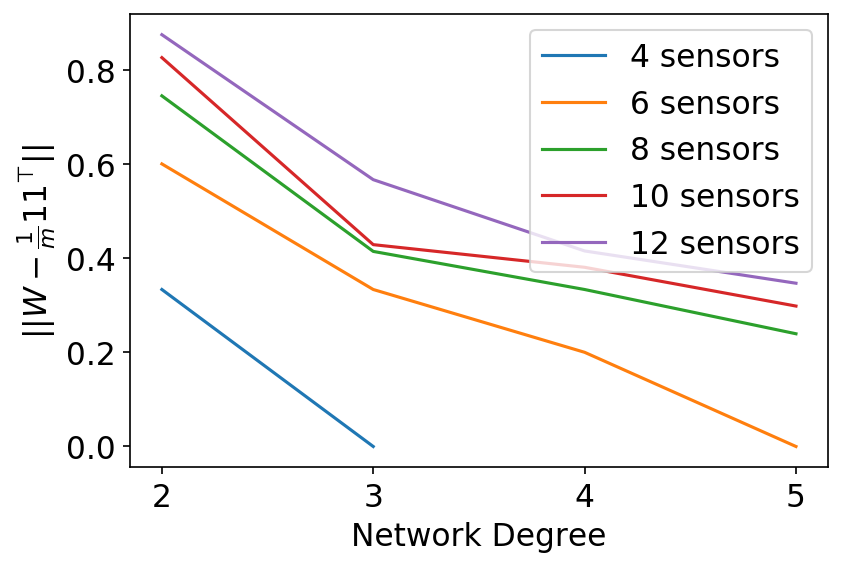

In [82]:
plt.figure(dpi=150)
for n_dim in [4,6,8,10,12]:
    degs = [deg for deg in  [2,3,4,5] if deg<n_dim]
    s = [best_networks[(n_dim,deg)][2] for deg in degs]
    plt.plot(degs,s,label='{} sensors'.format(n_dim))
    plt.xlabel('Network Degree')
    plt.ylabel(r'$||W-\frac{1}{m} 11^\top||$')
plt.xticks([2,3,4,5])
rc('font',size=15)
plt.legend()
plt.show()